# Download and extract video

In [0]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
!pip install pytube

In [0]:
import cv2
from pytube import YouTube
from pathlib import Path

In [0]:
%cd drive/My Drive/Colab Notebooks/EDN/pytorch-EverybodyDanceNow-master/notebook

/content/drive/My Drive/Colab Notebooks/EDN/pytorch-EverybodyDanceNow-master/notebook


In [0]:
save_dir = Path('../data/target/')
save_dir.mkdir(exist_ok=True)

img_dir = save_dir.joinpath('images')
img_dir.mkdir(exist_ok=True)

In [0]:
# Bruno Mars - That's What I Like
yt = YouTube('http://www.youtube.com/watch?v=PMivT7MJ41M')
yt.streams.first().download(save_dir, 'mv')

In [0]:
cap = cv2.VideoCapture(str(save_dir.joinpath('mv2.mp4')))
i = 0
while(cap.isOpened()):
    flag, frame = cap.read()
    if flag == False or i == 1000:
        break
    cv2.imwrite(str(img_dir.joinpath(f'img_{i:04d}.png')), frame)
    i += 1

In [0]:
for i in range(488):
    img = cv2.imread(f'../data/target/images/img_{i:04d}.png')
    transpose_img = img.transpose(1,0,2)
    clockwise = transpose_img[:,::-1]

# Pose estimation (OpenPose)

In [0]:
!pip3 install torch torchvision

    100% |████████████████████████████████| 519.5MB 29kB/s 
tcmalloc: large alloc 1073750016 bytes == 0x58826000 @  0x7f7ce11492a4 0x594e17 0x626104 0x51190a 0x4f5277 0x510c78 0x5119bd 0x4f5277 0x4f3338 0x510fb0 0x5119bd 0x4f5277 0x4f3338 0x510fb0 0x5119bd 0x4f5277 0x4f3338 0x510fb0 0x5119bd 0x4f6070 0x510c78 0x5119bd 0x4f5277 0x4f3338 0x510fb0 0x5119bd 0x4f6070 0x4f3338 0x510fb0 0x5119bd 0x4f6070
    100% |████████████████████████████████| 61kB 22.6MB/s 
    100% |████████████████████████████████| 2.0MB 5.3MB/s 
  Found existing installation: Pillow 4.0.0
    Uninstalling Pillow-4.0.0:
      Successfully uninstalled Pillow-4.0.0


In [0]:
import numpy as np
import matplotlib.pyplot as plt
import torch
from tqdm import tqdm

%matplotlib inline

In [0]:
openpose_dir = Path('../src/pytorch_Realtime_Multi-Person_Pose_Estimation/')

import sys
sys.path.append(str(openpose_dir))
sys.path.append('../src/utils')

%reload_ext autoreload
%autoreload 2

In [0]:
!pip install cython 

    100% |████████████████████████████████| 2.1MB 14.1MB/s 


In [0]:
!pip install pycocotools

    100% |████████████████████████████████| 1.5MB 14.6MB/s 
  Running setup.py bdist_wheel for pycocotools ... - \ | / done
  Stored in directory: /root/.cache/pip/wheels/dc/e6/36/0e1ae88c868eb42d3f92181b1c9bbd0b217a7ec3da6bd62e55
Successfully built pycocotools


In [0]:
!pip install tensorboardX

    100% |████████████████████████████████| 71kB 2.7MB/s 


In [0]:
!pip install torch-encoding

    100% |████████████████████████████████| 61kB 2.3MB/s 
    100% |████████████████████████████████| 163kB 23.8MB/s 
  Running setup.py bdist_wheel for torch-encoding ... - \ done
  Stored in directory: /root/.cache/pip/wheels/16/89/39/2edce77325f4625bcd28472dd1a9aa2c004c114ce5c1094af1
Successfully built torch-encoding


In [0]:
# openpose
from network.rtpose_vgg import get_model
from evaluate.coco_eval import get_multiplier, get_outputs

# utils
from openpose_utils import remove_noise, get_pose

In [0]:
import torch
torch.cuda.is_available()

True

In [0]:
b = openpose_dir.joinpath('pose_model.pth')

In [0]:
weight_name = b
model = get_model('vgg19')     
model.load_state_dict(torch.load(weight_name))
model = torch.nn.DataParallel(model).cuda()
model.float()
model.eval()
pass

Bulding VGG19


## check

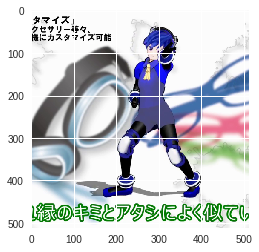

In [0]:
img_path = sorted(img_dir.iterdir())[438]
img = cv2.imread(str(img_path))
shape_dst = np.min(img.shape[:2])
# offset
oh = (img.shape[0] - shape_dst) // 2
ow = (img.shape[1] - shape_dst) // 2

img = img[oh:oh+shape_dst, ow:ow+shape_dst]
img = cv2.resize(img, (512, 512))
          
plt.imshow(img[:,:,[2, 1, 0]]) # BGR -> RGB

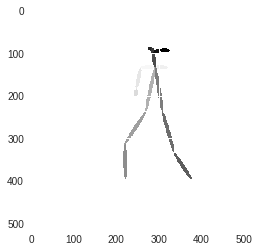

In [0]:
multiplier = get_multiplier(img)
with torch.no_grad():
    paf, heatmap = get_outputs(multiplier, img, model, 'rtpose')
    
r_heatmap = np.array([remove_noise(ht)
                      for ht in heatmap.transpose(2, 0, 1)[:-1]])\
                     .transpose(1, 2, 0)
heatmap[:, :, :-1] = r_heatmap
param = {'thre1': 0.1, 'thre2': 0.05, 'thre3': 0.5}
label = get_pose(param, heatmap, paf)

plt.imshow(label)

## make label images for pix2pix

In [0]:
train_dir = save_dir.joinpath('train')
train_dir.mkdir(exist_ok=True)

train_img_dir = train_dir.joinpath('train_img')
train_img_dir.mkdir(exist_ok=True)
train_label_dir = train_dir.joinpath('train_label')
train_label_dir.mkdir(exist_ok=True)

for idx in tqdm(range(438, 438+70)):
    img_path = img_dir.joinpath(f'img_{idx:04d}.png')
    img = cv2.imread(str(img_path))
    shape_dst = np.min(img.shape[:2])
    oh = (img.shape[0] - shape_dst) // 2
    ow = (img.shape[1] - shape_dst) // 2

    img = img[oh:oh+shape_dst, ow:ow+shape_dst]
    img = cv2.resize(img, (512, 512))
    multiplier = get_multiplier(img)
    with torch.no_grad():
        paf, heatmap = get_outputs(multiplier, img, model, 'rtpose')
    r_heatmap = np.array([remove_noise(ht)
                      for ht in heatmap.transpose(2, 0, 1)[:-1]])\
                     .transpose(1, 2, 0)
    heatmap[:, :, :-1] = r_heatmap
    param = {'thre1': 0.1, 'thre2': 0.05, 'thre3': 0.5}
    label = get_pose(param, heatmap, paf)
    
    cv2.imwrite(str(train_img_dir.joinpath(f'img_{idx:04d}.png')), img)    
    cv2.imwrite(str(train_label_dir.joinpath(f'label_{idx:04d}.png')), label)
    
torch.cuda.empty_cache()

100%|██████████| 70/70 [08:56<00:00,  7.36s/it]
